# Tarea 2 - Procesamiento distribuido y redes neuronales profundas

In [66]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
import os 
import torch
import PIL
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
from PIL import Image
from torchvision import models, datasets, transforms
from keras.applications.imagenet_utils import decode_predictions
from skimage.segmentation import slic, mark_boundaries
from skimage.io import imshow
from scipy.stats import bernoulli
from sklearn.metrics import pairwise_distances
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN, Birch,MiniBatchKMeans
from sklearn.neighbors import KNeighborsClassifier
%matplotlib inline
# Path del directorio
#path_dir = os.getcwd() + '/drive/My Drive/MA6202/T2'
#os.chdir(path_dir)
# Se asigna un valor de reproductibilidad
torch.manual_seed(6202)
#np.random.seed(seed=6202)

In [68]:
os.getcwd()

'/content/drive/My Drive/MA6202/T2'

## P3. Interpretabilidad 

### 1

In [69]:
preprocesamiento = transforms.Compose([transforms.Resize(size=299, interpolation=2),
                                     transforms.CenterCrop(299),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                          std=[0.229, 0.224, 0.225], 
                                                          inplace=True)
                                     ])

### 2

In [70]:
#modelo = torch.hub.load('pytorch/vision:v0.6.0', 'inception_v3', pretrained=True)
modelo = models.inception_v3(pretrained=True)
modelo.eval();

In [71]:
#Se trabaja con la GPU para mayor eficiencia:
dev = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")
dev

device(type='cuda')

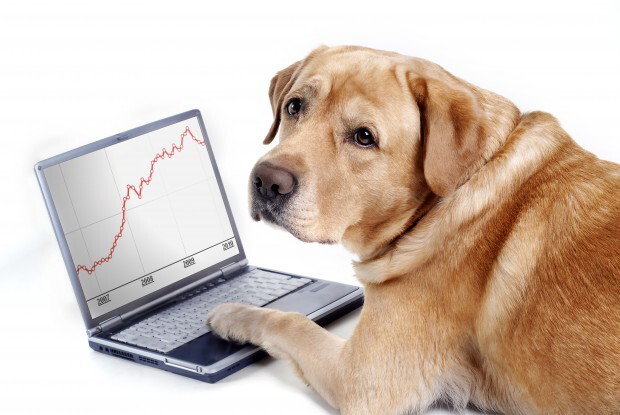

In [72]:
# Se carga la imagen de control
imagen_control = Image.open("imagen_control.jpg")
imagen_control

In [73]:
# Se procesa la imagen de control bajo el preprocesador antes creado
imagen_procesada = preprocesamiento(imagen_control)
imagen_procesada

tensor([[[ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
         [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
         [ 2.2318,  2.2318,  2.2318,  ...,  2.2318,  2.2318,  2.2318],
         ...,
         [ 2.2489,  2.2489,  2.2489,  ...,  0.2624,  0.3652,  0.3994],
         [ 2.2489,  2.2489,  2.2489,  ...,  0.2282,  0.3481,  0.3652],
         [ 2.2489,  2.2489,  2.2489,  ...,  0.1939,  0.2967,  0.3309]],

        [[ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
         [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
         [ 2.4111,  2.4111,  2.4111,  ...,  2.4111,  2.4111,  2.4111],
         ...,
         [ 2.4286,  2.4286,  2.4286,  ..., -0.0049,  0.0826,  0.1352],
         [ 2.4286,  2.4286,  2.4286,  ..., -0.0399,  0.0826,  0.1001],
         [ 2.4286,  2.4286,  2.4286,  ..., -0.0749,  0.0301,  0.0651]],

        [[ 2.6400,  2.6400,  2.6400,  ...,  2.6400,  2.6400,  2.6400],
         [ 2.6400,  2.6400,  2.6400,  ...,  2

In [74]:
imagen_procesada.shape

torch.Size([3, 299, 299])

In [75]:
# Se genera la red para procesar la imagen de control
input_batch = imagen_procesada.unsqueeze(0) # create a mini-batch as expected by the model

# mueve el input y modelo a la GPU en caso de estar disponible
input_batch = input_batch.to(dev)
modelo.to(dev)

# arreglo de largo 1000, con scores de confianza sobre más de 1000 clases de Imagenet
output = modelo(input_batch)

# Se normalizan los scores para obtener probabilidades.
predicciones = torch.nn.functional.softmax(
    output[0], dim=0).cpu().detach().numpy().reshape([-1,1]).T

La clase más probable es Labrador_retriever, con una probabilidad de 0.72.

In [76]:
decode_predictions(predicciones)

[[('n02099712', 'Labrador_retriever', 0.7240359),
  ('n03832673', 'notebook', 0.02159083),
  ('n02087394', 'Rhodesian_ridgeback', 0.017078092),
  ('n02099601', 'golden_retriever', 0.016017713),
  ('n03642806', 'laptop', 0.012681216)]]

In [77]:
# Se recupera la clase predicha por la red sobre la imagen de control
prediccion_control = decode_predictions(predicciones)[0][0][1] # Labrador_retriever
prediccion_control

'Labrador_retriever'

### 3

In [78]:
# Se reajustan las dimensiones de la imagen procesada para ser procesada como
# ndarray por slic(). Tensor(C,H,W) -> ndarray(H,W,C)
imagen_procesada = np.transpose(imagen_procesada.numpy(),[1,2,0])
imagen_procesada.shape

(299, 299, 3)

In [79]:
# Se procesa la imagen a traves de slic()
imagen_segmentada = slic(imagen_procesada,n_segments=80)
imagen_segmentada.shape

(299, 299)

/usr/local/lib/python3.6/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


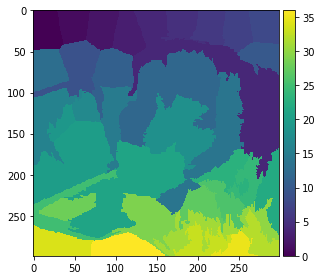

In [80]:
# Visualizamos primero los labels de la segmentación
imshow(imagen_segmentada)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


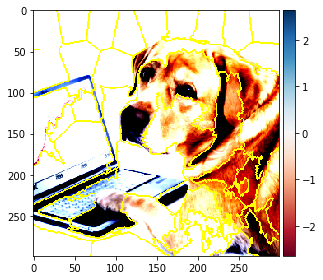

In [81]:
# Visualizamos la imagen de control con los bordes inducidos por los superpixeles. 
imshow(mark_boundaries(image=imagen_procesada,label_img=imagen_segmentada))

### 4

In [82]:
# Obtenemos los label únicos.
print(np.unique(imagen_segmentada))
print(len(np.unique(imagen_segmentada)))
# Notamos que van de 0 a 36. Luego son un total de 37 labels.
n_superpixeles = len(np.unique(imagen_segmentada))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]
37


In [83]:
# Número de perturbaciones a realizar
n_perturbaciones = 1000 

# Se construye el arreglo de perturbaciones
#perturbaciones = bernoulli.rvs(0.5, loc=0, size=(n_perturbaciones,n_superpixeles))

# Se guardan en un .npy para luego solo importar.
#np.save("perturbaciones.npy",perturbaciones)

# Se cargan las perturbaciones previamente calculadas
perturbaciones = np.load("perturbaciones.npy")

# Notamos que son 1000 perturbaciones distintas para los 37 labels
print(perturbaciones.shape)

# Vemos una de las perturbaciones
print(perturbaciones[0])

(1000, 37)
[1 0 1 0 0 0 0 0 0 1 0 1 1 1 0 1 0 1 1 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 0 1 1]


### 5

In [84]:
def perturbar_imagen(imagen,perturbacion,segmentacion):
  '''Perturba una imagen ndarray.
  
  Genera un ndarray de dimensiones imagen.shape donde los canales de color
  de sus pixeles según el arreglo perturbacion.
  '''
  I,J,_ = imagen.shape
  imagen_perturbada=np.zeros_like(imagen)
  for i in range(I):
    for j in range(J):
      imagen_perturbada[i,j,:] = imagen_procesada[i,j,:]*perturbacion[segmentacion[i,j]]
  return imagen_perturbada

In [85]:
# Se genera un arreglo de imagenes perturbadas según el arreglo perturbaciones.
#imagenes_perturbadas = np.array([perturbar_imagen(
#    imagen_procesada,perturbacion,imagen_segmentada) for perturbacion in perturbaciones])
#np.save("imagenes_perturbadas.npy" ,arr=imagenes_perturbadas)

# Se carga el arreglo de imagenes perturbadas
imagenes_perturbadas = np.load("imagenes_perturbadas.npy")

In [86]:
# Se crean subarreglos de los primeros 10 y 100 imagenes por memoria.
#imagenes_perturbadas_10_2 = imagenes_perturbadas[:10,:,:,:]
#imagenes_perturbadas_100 = imagenes_perturbadas[:100,:,:,:]
#np.save("imagenes_perturbadas_10.npy",arr=imagenes_perturbadas_10)
#np.save("imagenes_perturbadas_100.npy",arr=imagenes_perturbadas_100)

# Se cargan los subarreglos
#imagenes_perturbadas_10 = np.load("imagenes_perturbadas_10.npy")
#imagenes_perturbadas_100 = np.load("imagenes_perturbadas_100.npy")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'perturbaciones[2]')

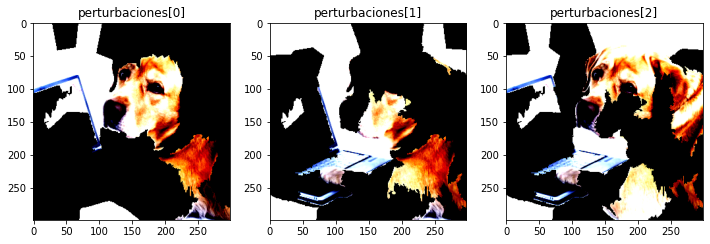

In [87]:
# Se muestran las 3 primeras perturbaciones de la imagen de control procesada
fig, ax = plt.subplots(nrows=1, ncols=3,figsize=[12,13])
#fig.suptitle('Perturbaciones de imagen de control')

ax[0].imshow(imagenes_perturbadas[0])
ax[0].set_title('perturbaciones[0]')

ax[1].imshow(imagenes_perturbadas[1])
ax[1].set_title('perturbaciones[1]')

ax[2].imshow(imagenes_perturbadas[2])
ax[2].set_title('perturbaciones[2]')

### 6

In [88]:
# Se crea el vector y
y = np.zeros(n_perturbaciones)

# Se procede a llenar y segun lo solicitado
for i in range(len(y)):
  imagen_i = imagenes_perturbadas[i]
  input_batch_i = torch.from_numpy(np.transpose(imagen_i,[2,0,1])).unsqueeze(0)
  input_batch_i = input_batch_i.to(dev)

  # Se calculan las probabilidades de cada clase
  output_i = modelo(input_batch_i)
  predicciones_i = torch.nn.functional.softmax(
    output_i[0], dim=0).cpu().detach().numpy().reshape([-1,1]).T
  
  # Se recupera la clase más probable
  prediccion_i = decode_predictions(predicciones_i)[0][0][1]
  
  # En caso de coincidir con la prediccion de la imagen de control
  if prediccion_i == prediccion_control:
    y[i] = 1

print('Cantidad de predicciones acertadas: {}'.format(sum(y)))

Cantidad de predicciones acertadas: 385.0


### 7

In [89]:
# Se crea un arreglo de 1's que corresponde a "no perturbar" la imagen original
imagen_original = np.ones(n_superpixeles).reshape(1,-1)
imagen_original

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1.]])

In [90]:
# Se calculan las distancias coseno
distancias = 1 - pairwise_distances(perturbaciones,imagen_original, metric='cosine').ravel()
#distancias = pairwise_distances(perturbaciones,imagen_original, metric='cosine').ravel()
print(distancias.shape)
#print(distancias)

(1000,)


In [91]:
# Se calcula pi_x
sigma = 0.25
pi_x = np.exp(-(distancias**2)/sigma**2)
print(pi_x.shape)

(1000,)


### 8

In [92]:
# Se genera el conjunto de entrenamiento D_p concatenando el vector y sobre
# el arreglo de perturbaciones
D_p = np.column_stack([perturbaciones,y])
D_p.shape

(1000, 38)

### 9

In [93]:
# Se crea el modelo de regresión logística y se ajusta a los datos de entrenamiento 
modelo_logistico = LogisticRegression()
modelo_logistico.fit(X=D_p[:,:-1], y=D_p[:,-1:].ravel(), sample_weight=pi_x)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

#### DISCUSION:

### 10

In [94]:
# Se guarda el vector con los coeficientes del ajuste anterior
coeficientes = modelo_logistico.coef_[0]

# Se consideran los super-pixeles más relevantes(con mayor peso) y los menos
# relevantes(menor peso), en la predicción.
n_sp = 4
mejores_superpixeles = np.argsort(coeficientes)[-n_sp:]
peores_superpixeles = np.argsort(coeficientes)[:n_sp]
print("Superpixeles de mayor peso: ", mejores_superpixeles)
print("Superpixeles de menor peso: ", peores_superpixeles)

Superpixeles de mayor peso:  [26  4 18 12]
Superpixeles de menor peso:  [21 15  0 34]


In [95]:
# Se crea una perturbacion mascara con los mejores_superpixeles
mascara_mejores, mascara_peores = np.zeros(n_superpixeles), np.zeros(n_superpixeles) 
mascara_mejores[mejores_superpixeles]= True #Activa los mejores superpixeles
mascara_peores[peores_superpixeles]= True #Activa los peores superpixeles

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Peores')

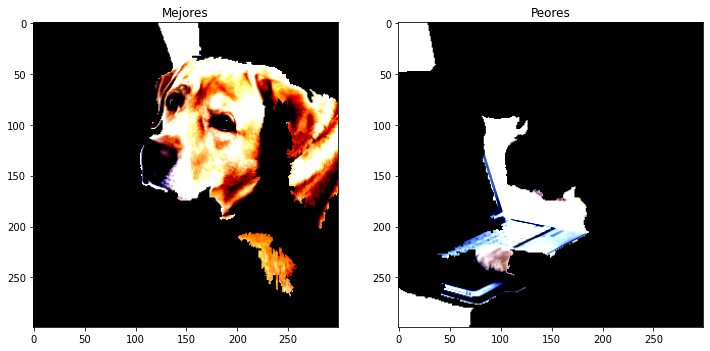

In [96]:
# Se perturba la imagen con la mascara
imagen_mascara_mejores = perturbar_imagen(imagen_procesada, mascara_mejores, imagen_segmentada)
imagen_mascara_peores = perturbar_imagen(imagen_procesada, mascara_peores, imagen_segmentada)

# Se muestra la imagen 
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=[12,13])
ax[0].imshow(imagen_mascara_mejores)
ax[0].set_title('Mejores')
ax[1].imshow(imagen_mascara_peores)
ax[1].set_title('Peores')

#### DISCUSION:

### 11

In [97]:
# Se crea un nuevo esquema de procesamiento para convertir la imagen de control
# a grayscale.
procesamiento_gs = transforms.Compose([transforms.Resize(size=299, interpolation=2),
                                     transforms.CenterCrop(299),
                                     ])

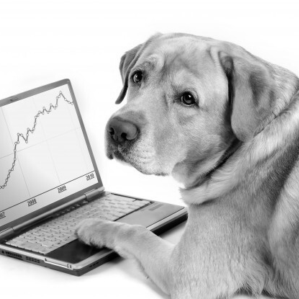

In [98]:
# Procedemos a hacer la transformacion
imagen_procesada_gs = procesamiento_gs(imagen_control)
#imagen_procesada_gs = transforms.ToPILImage(mode="RGB")(imagen_procesada_gs)
imagen_procesada_gs = imagen_procesada_gs.convert("L")
imagen_procesada_gs

In [99]:
# La convertimos en arreglo de numpy para trabajar en la clusterizacion
imagen_procesada_gs = np.asarray(imagen_procesada_gs)
print(imagen_procesada_gs.shape)
imagen_procesada_gs

(299, 299)


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [254, 254, 254, ..., 254, 254, 254],
       ...,
       [255, 255, 255, ..., 121, 126, 129],
       [255, 255, 255, ..., 119, 126, 127],
       [255, 255, 255, ..., 117, 123, 125]], dtype=uint8)

In [100]:
# Creamos el conjunto de entrenamiento X
X = np.array( [ [i,j,imagen_procesada_gs[i,j]]
               for i in range(299) for j in range(299)])

# Notamos que tiene largo 299*299 y cada fila corresponde a una observación
# donde las primeras 2 componentes son espaciales y la tercera es el color
print(X.shape)
X

(89401, 3)


array([[  0,   0, 255],
       [  0,   1, 255],
       [  0,   2, 255],
       ...,
       [298, 296, 117],
       [298, 297, 123],
       [298, 298, 125]])

In [101]:
# Fijamos el numero de clusters que queremos
n_clusters = 10

In [102]:
# KMeans
# Creamos el cluster KMeans con n_cluster clusters y ajustamos al conjunto de entrenamiento 
km_cluster = KMeans(n_clusters=n_clusters)
km_cluster.fit_predict(X)

# Obtenemos los labels(superpixeles) y los centros de cada cluster
km_labels, km_centers = km_cluster.labels_, km_cluster.cluster_centers_.squeeze()
print(km_labels.shape)
print(km_labels)
print(np.unique(km_labels))

(89401,)
[5 5 5 ... 7 7 7]
[0 1 2 3 4 5 6 7 8 9]


In [103]:
# Recuperamos la estructura original de la imagen descrita por superpixeles
km_labels = km_labels.reshape(299,299)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


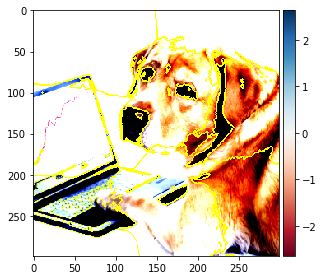

In [104]:
# Obtenemos una visualización de los bordes que inducen los superpixeles 
# obtenidos por KMeans sobre la imagen de control
imshow(mark_boundaries(image=imagen_procesada,label_img=km_labels))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'superpixel 4')

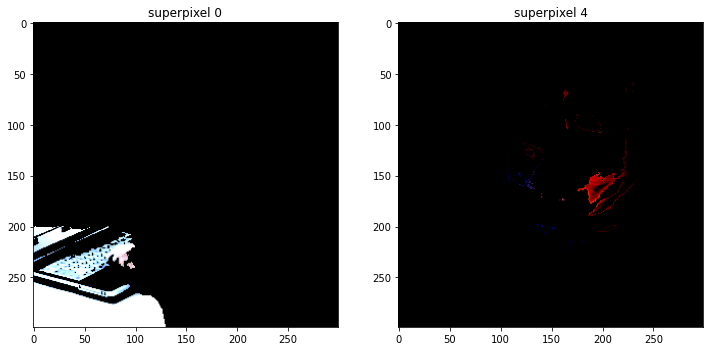

In [105]:
# Visualizamos algunos clusters obtenidos de éste metodo
i,j = 0,4
mascara_i, mascara_j = np.zeros(n_clusters),np.zeros(n_clusters)
mascara_i[i], mascara_j[j]= True, True
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=[12,13])
ax[0].imshow(perturbar_imagen(imagen_procesada,mascara_i,km_labels))
ax[0].set_title('superpixel {}'.format(i))
ax[1].imshow(perturbar_imagen(imagen_procesada,mascara_j,km_labels))
ax[1].set_title('superpixel {}'.format(j))

In [106]:
# MiniBatchKMeans
# Creamos el cluster MeanShift y ajustamos al conjunto de entrenamiento 
mbkm_cluster = MiniBatchKMeans(n_clusters=n_clusters, batch_size=16, random_state=0)
mbkm_cluster.fit_predict(X)

# Obtenemos los labels(superpixeles) y los centros de cada cluster
mbkm_labels, mbkm_centers = mbkm_cluster.labels_, mbkm_cluster.cluster_centers_.squeeze()
print(mbkm_labels.shape)
print(mbkm_labels)
print(np.unique(mbkm_labels))

(89401,)
[6 6 6 ... 2 2 2]
[0 1 2 3 4 5 6 7 8 9]


In [107]:
# Recuperamos la estructura original de la imagen descrita por superpixeles
mbkm_labels = mbkm_labels.reshape(299,299)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


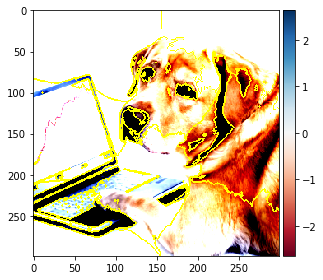

In [108]:
# Obtenemos una visualización de los bordes que inducen los superpixeles 
# obtenidos por KMeans sobre la imagen de control
imshow(mark_boundaries(image=imagen_procesada,label_img=mbkm_labels))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Cluster 2')

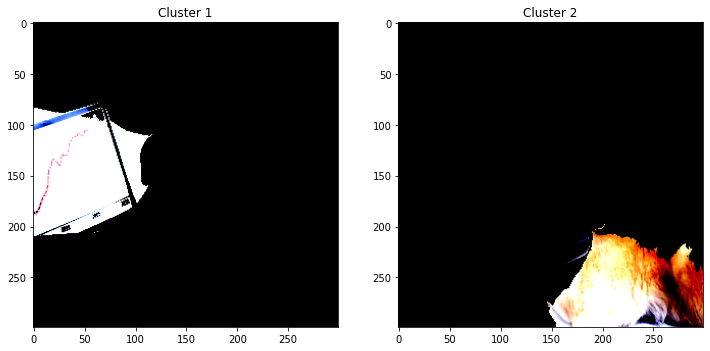

In [112]:
# Visualizamos algunos clusters obtenidos de éste metodo
i,j = 1,2
mascara_i, mascara_j = np.zeros(n_clusters),np.zeros(n_clusters)
mascara_i[i], mascara_j[j]= True, True
fig, ax = plt.subplots(nrows=1, ncols=2,figsize=[12,13])
ax[0].imshow(perturbar_imagen(imagen_procesada, mascara_i, mbkm_labels))
ax[0].set_title('Cluster {}'.format(i))
ax[1].imshow(perturbar_imagen(imagen_procesada, mascara_j, mbkm_labels))
ax[1].set_title('Cluster {}'.format(j))

### 12

#### KMeans